<a href="https://colab.research.google.com/github/reggiebain/data-projects/blob/main/Deep_Learning_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Certified Fresh vs. Fresh vs. Rotten
- In this notebook, we use deep learning NLP techniques to predict the ordinal ratings of movies on Rotten Tomatoes.
- Our task will be to predict the "review type" meaning Fresh, or Rotten. Here, we will focus on critic reviews. NOTE: Critic review does not necessarily dictate the tomatometers status overall review.
- In a separate project, we focused on data from audience reviews and found a highly successful classifier. 
- We can train a pre-trained NLP classifier on the sentiment of critic reviews using the "review_type" and "review_content" features

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [95]:
# Import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import statistics as stats

import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#from bert_sklearn import BertClassifier
#from bert_sklearn import BertRegressor
#from bert_sklearn import BertTokenClassifier
#from bert_sklearn import load_model

In [3]:
# Read in critic reviews of movies
critics = pd.read_csv('/content/drive/MyDrive/Data-Science/rotten_tomatoes_critic_reviews_50k.csv')
movies = pd.read_csv('/content/drive/MyDrive/Data-Science/rotten_tomatoes_movies.csv')
critics.head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...


In [4]:
# Merge data sets to get movie title and tomatometer_status (which is our target).
merged = pd.merge(critics, movies, on='rotten_tomatoes_link')
data = merged[['rotten_tomatoes_link','critic_name','movie_title','review_content','review_type', 'tomatometer_status']]

# Drop rows where there is no target
data_nona = data.dropna(subset=['review_type', 'review_content'])
data_nona.head(1)

,rotten_tomatoes_link,critic_name,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Andrew L. Urban,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten


Text(0.5, 1.0, 'Tomatometer Status')

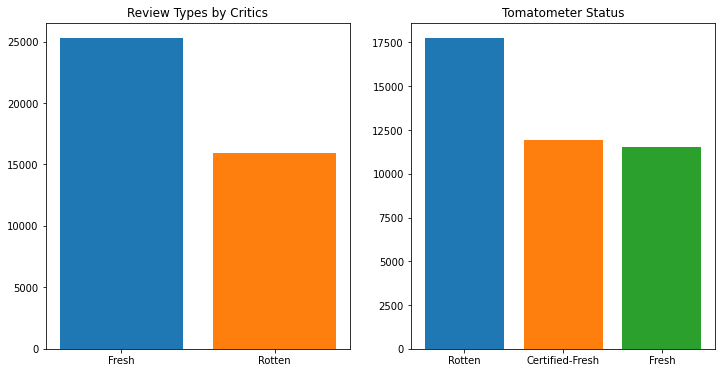

In [9]:
# Declare color map
colormap = mpl.cm.get_cmap('tab10')
# Drop entries with missing data
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig1 = axs[0].bar(x=data_nona.review_type.unique(),height=data_nona.review_type.value_counts(),color=colormap.colors)
axs[0].set_title('Review Types by Critics')
#axs[0].bar_label(fig1, padding = 3)
fig2 = axs[1].bar(x=data_nona.dropna(subset=['tomatometer_status']).tomatometer_status.unique(),height=(data_nona.dropna(subset=['tomatometer_status'])).tomatometer_status.value_counts(),color=colormap.colors)
axs[1].set_title('Tomatometer Status')
#axs[1].bar_label(fig2, padding=3)

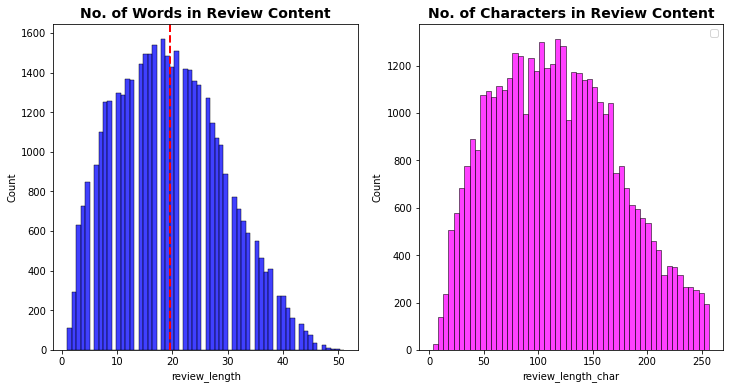

In [109]:
# Plot the distribution of lengths of the reviews (number of characters)
# First get sentence lengths as a new column
data_nona["review_length"] = data_nona["review_content"].apply(lambda x: len(x.split()))
data_nona['review_length_char'] = data_nona['review_content'].apply(lambda x: len(x))
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.histplot(data_nona['review_length'], ax=axs[0], color='blue')
axs[0].set_title('No. of Words in Review Content', fontsize=14, fontweight='bold')
sns.histplot(data_nona['review_length_char'], ax=axs[1], color='magenta')
axs[1].set_title('No. of Characters in Review Content', fontsize=14, fontweight='bold')

# Add averages 
avg = np.mean(data_nona['review_length'])
axs[0].axvline(avg, color='red', linestyle='dashed', linewidth=2, label='Average')
plt.legend()
plt.show()

#### Isolate training data and Preprocess
- [X] Isolate relevant training/validation/testing data and drop na's
- [X] Define preprocessing function
- [X] Split into train/val/test tests with SKLearn
- [ ] Create TF/Keras dataset. 
- [X] Define RNN with LSTMs etc.
- [X] Evaluate Accuracy

In [10]:
data_nona.head(1)

,rotten_tomatoes_link,critic_name,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Andrew L. Urban,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten


In [11]:
# Isolate and Preprocess Data
import re

data = data_nona[['review_content', 'review_type']]
proc_data = pd.DataFrame()
def preprocess(input):
  input = re.sub('<br\\s*/?,\(\)>', ' ',input)
  input = re.sub("[^a-zA-Z']", ' ', input)
  input = input.lower()
  return input

# Preprocess review content to clean up review text
proc_data['review_content'] = data['review_content'].apply(lambda x: preprocess(x))

# Assign 0/1 (or ordinal encoding) to review labels
proc_data['review_type'] = data.review_type.apply(lambda x: 0 if x=='Rotten' else 1)

In [12]:
from sklearn.model_selection import train_test_split 
X_train_full, X_test, y_train_full, y_test = train_test_split(proc_data[['review_content']], proc_data[['review_type']], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1)

In [13]:
# For tokenizing, create lists of training and testing data and labels
import numpy as np 
X_train_list = X_train['review_content'].tolist()
X_val_list = X_val['review_content'].tolist()
X_test_list = X_test['review_content'].tolist()


y_train_list = np.array(y_train['review_type'].tolist())
y_val_list = np.array(y_val['review_type'].tolist())
y_test_list = np.array(y_test['review_type'].tolist())

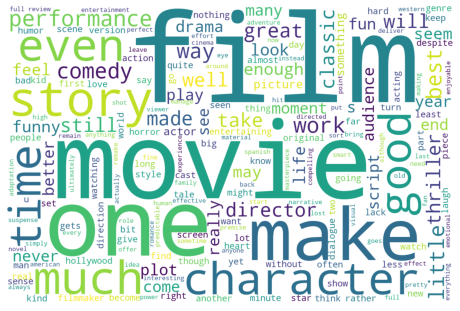

In [53]:
# Create quick word cloud on training data
from wordcloud import WordCloud 
# Create giant list of all word in all sentences
words = ' '.join(X_train_list)
wordcloud = WordCloud(width=1200, height= 800, background_color='white').generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [62]:
# Create and train a tokenizer on the training data. Then create a word index.
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

vocab_size = 5000

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_list)
word_index = tokenizer.word_index

In [63]:
# Create sequences for training/val/test data
sequences = tokenizer.texts_to_sequences(X_train_list)
val_sequences = tokenizer.texts_to_sequences(X_val_list)
test_sequences = tokenizer.texts_to_sequences(X_test_list)

In [110]:
# Testing the sequences
print(sequences[1])
print(X_train_list[1])
print(f'always = {word_index["always"]}, a = {word_index["a"]}, classic = {word_index["classic"]}')

[310, 2, 90]
always a classic
always = 310, a = 2, classic = 90


In [65]:
# Created list of padded numerical sequences with uniform length 'max_len'
max_len = 200
padded = pad_sequences(sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

In [66]:
print(padded[1])

[310   2  90   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [77]:
# Defining a simple model
num_oov_buckets = 1000
embed_size = 128
lstm_out = 196

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_length=max_len),
    keras.layers.SpatialDropout1D(0.4),
    keras.layers.LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

#model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(vocab_size, embed_size, input_length=max_len),
#    tf.keras.layers.GlobalAveragePooling1D(),
#    tf.keras.layers.Dense(6, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

In [78]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          768000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 200, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 196)               254800    
                                                                 
 dense_5 (Dense)             (None, 1)                 197       
                                                                 
Total params: 1,022,997
Trainable params: 1,022,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 20
history = model.fit(padded, y_train_list, epochs = num_epochs, validation_data = (val_padded, y_val_list))

In [64]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [34]:
# Alternate model using Bi-Directional 1 layer LSTM
model2 = keras.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_length=max_len),
    keras.layers.Bidirectional(layers.LSTM(int(embed_size/2))),
    #keras.layers.LSTM(15, dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          1408000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,506,945
Trainable params: 1,506,945
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Implement model checkpoins to get NN performance at its best
from keras.callbacks import ModelCheckpoint
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
num_epochs=10
history = model2.fit(padded, y_train_list, epochs = num_epochs, validation_data = (val_padded, y_val_list), callbacks=[checkpoint2])

Epoch 1/10
1043/1043 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7446
Epoch 1: val_accuracy improved from -inf to 0.80124, saving model to best_model2.hdf5
1043/1043 [==============================] - 279s 264ms/step - loss: 0.5140 - accuracy: 0.7446 - val_loss: 0.4239 - val_accuracy: 0.8012
Epoch 2/10
1043/1043 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8426
Epoch 2: val_accuracy improved from 0.80124 to 0.80205, saving model to best_model2.hdf5
1043/1043 [==============================] - 272s 261ms/step - loss: 0.3559 - accuracy: 0.8426 - val_loss: 0.4183 - val_accuracy: 0.8020
Epoch 3/10
1043/1043 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8860
Epoch 3: val_accuracy did not improve from 0.80205
1043/1043 [==============================] - 289s 277ms/step - loss: 0.2647 - accuracy: 0.8860 - val_loss: 0.4550 - val_accuracy: 0.7958
Epoch 4/10
1043/1043 [==============================] - ETA: 0s - los

In [39]:
!mkdir -p saved_model
model2.save('saved_model/my_model_lstm2') 

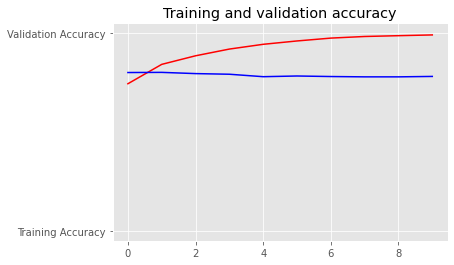

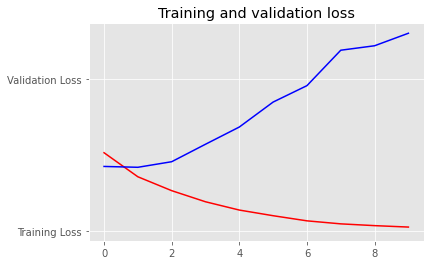

<Figure size 432x288 with 0 Axes>

In [65]:
plot_learning(history)

In [60]:
best_model = keras.models.load_model("best_model2.hdf5")
test_loss, test_acc = best_model.evaluate(test_padded, y_test_list, verbose=2)
print('Model accuracy: ',test_acc)

129/129 - 8s - loss: 0.4370 - accuracy: 0.7883 - 8s/epoch - 66ms/step
Model accuracy:  0.7883495092391968


In [61]:
# Create predictions from the best model on the test data
predictions = best_model.predict(test_padded)

129/129 [==============================] - 9s 67ms/step


In [69]:
# Create y_pred, which is a list of 0's and 1's based on the probs we got from the sigmoid later
y_pred = np.array([1 if p > 0.5 else 0 for p in predictions])

array([1, 0, 1, ..., 0, 0, 1])

In [70]:
# Plot results via confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_list, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1594
           1       0.83      0.83      0.83      2526

    accuracy                           0.79      4120
   macro avg       0.78      0.78      0.78      4120
weighted avg       0.79      0.79      0.79      4120



In [ ]:
### TODO: Predict Sentiment of Individual Movie Review

In [71]:

# Use model to predict sentiment of a new movie review
def predict_movie_status(prediction):
    
    pos = (prediction == 1).sum()/len(prediction)
    
    prediction = 'Fresh' if pos >= 0.50 else 'Rotten'
    
    print(f'Positive review:{pos:.2f}%')
    print(f'Movie status: {prediction}')

In [84]:
df = data_nona.loc[data_nona['movie_title'] == 'Titanic']
df.head()

,rotten_tomatoes_link,critic_name,movie_title,review_content,review_type,tomatometer_status
33514,m/1056130-titanic,Christopher Null,Titanic,fair enough,Fresh,Fresh
33515,m/1056130-titanic,John J. Puccio,Titanic,"...a good motion picture despite its shallow, ...",Fresh,Fresh
33516,m/1056130-titanic,Ken Hanke,Titanic,Manages to tell its tale in a compact 98 minut...,Fresh,Fresh
33518,m/1056130-titanic,James Sanford,Titanic,"Exciting, well-acted version of the infamous v...",Fresh,Fresh
33519,m/1056130-titanic,Ryan Cracknell,Titanic,Not as big as James Cameron's computer-generat...,Fresh,Fresh


In [85]:
#data_nona.movie_title.unique().tolist()

In [ ]:
# Get a prediction
the_sequence = tokenizer.texts_to_sequences(X_train_list)
padded = pad_sequences(sequences, maxlen=max_len)
y_predicted_bol = best_model.predict(vectorizer.transform(df_bol['review_content']).toarray())
predict_movie_status(y_predicted_bol)